In [1]:
import os
import IPython.display as ipd
import numpy as np
import random
import librosa
import matplotlib.pyplot as plt
# 
from pathlib import Path
import pandas as pd

SEED = 1312
np.random.seed(SEED)
random.seed(SEED)

In [2]:
# Path to dataset: structured as /dataset/{genre}/*.wav
DATASET_PATH = Path("data/ELECTRONIC_MUSIC_V2")
GENRES = ["Techno", "House"]

In [3]:
# Storage
filepaths = []
durations = []
sr_list = []
genre_list = []

# Basic Stats: Duration, Sampling Rate
for genre in GENRES:
    genre_path = DATASET_PATH / genre
    for audio_file in genre_path.glob("*.wav"):
        try:
            y, sr = librosa.load(audio_file, sr=None)
            duration = librosa.get_duration(y=y, sr=sr)
            filepaths.append(audio_file)
            durations.append(duration)
            sr_list.append(sr)
            genre_list.append(genre)
        except Exception as e:
            print(f"Failed to load {audio_file}: {e}")

# Create DataFrame
electronic_tracks_df = pd.DataFrame({
    "filepath": filepaths,
    "genre": genre_list,
    "duration_sec": durations,
    "sampling_rate": sr_list
})

electronic_tracks_df.head()

filepath   genre  duration_sec  \
0  data/ELECTRONIC_MUSIC_V2/Techno/Electronic mus...  Techno          10.0   
1  data/ELECTRONIC_MUSIC_V2/Techno/Music, Techno_...  Techno          10.0   
2  data/ELECTRONIC_MUSIC_V2/Techno/Music, Techno,...  Techno          10.0   
3  data/ELECTRONIC_MUSIC_V2/Techno/Electronic mus...  Techno          10.0   
4  data/ELECTRONIC_MUSIC_V2/Techno/Music, Techno_...  Techno          10.0   

   sampling_rate  
0          16000  
1          16000  
2          16000  
3          16000  
4          16000

In [4]:
electronic_tracks_df.iloc[:, 1:].value_counts()

genre   duration_sec  sampling_rate
House   10.0          16000            39
Techno  10.0          16000            29
Name: count, dtype: int64

In [5]:
FRAME_LENGTH = 2048
HOP_LENGTH = FRAME_LENGTH // 4

FRAME_LENGTH, HOP_LENGTH

(2048, 512)

In [6]:
from utils import extract_features

feature_flags = {
    "zcr": True,
    "centroid": True,
    "onset_strength": True,
    "mfcc": True,
    "chroma": True,
    "spectral_bandwidth": True,
    "spectral_rolloff": True,
    "rms": True,
    "spectral_contrast": False,
    "tonnetz": False,
    "mel_spectrogram": False,
    "tempogram": False
}

In [7]:
X = []
y = []

for fp, label in zip(electronic_tracks_df["filepath"], electronic_tracks_df["genre"]):
    try:
        audio, sr = librosa.load(fp, sr=None)
        _x = extract_features(filepath=fp, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, segment_duration=10, selected_features=feature_flags)
        
        X.append(_x)
        y.append(label)
    except Exception as e:
        print(f"Failed on {fp}: {e}")

X_segments = np.stack(X)  # shape: (samples, time_steps, features)
y_segments = np.array(y)  # shape: (samples,)

X_segments.shape, y_segments.shape

((68, 1, 313, 31), (68,))

### Treat each segment as an input instance

In [8]:
X = X_segments.reshape(-1, X_segments.shape[2], X_segments.shape[3]).astype(np.float32)
X.shape, X.dtype

((68, 313, 31), dtype('float32'))

In [9]:
from utils import get_feature_names

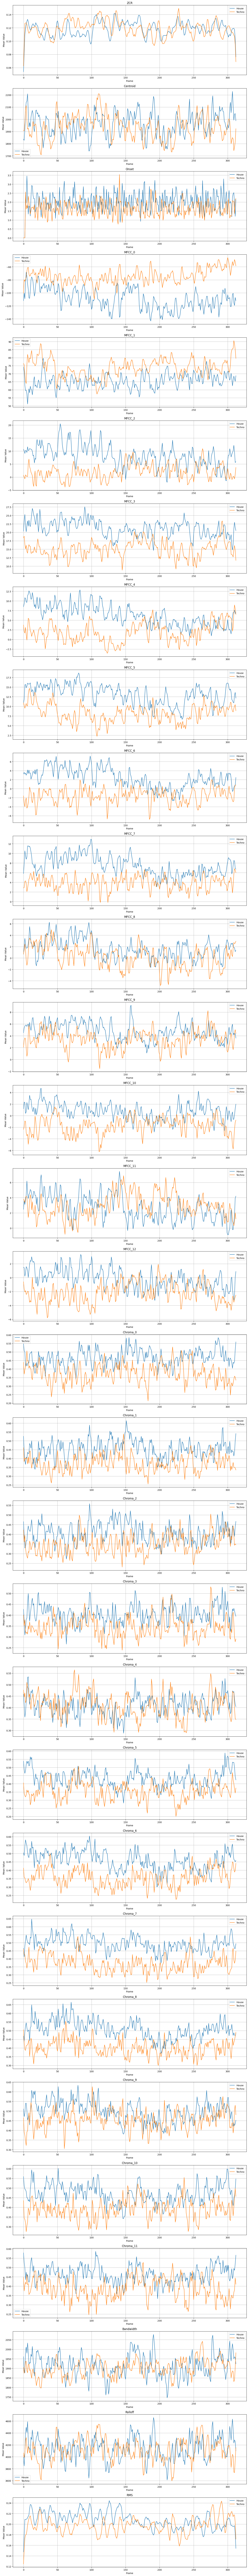

In [10]:
n_features = X.shape[2]
n_frames = X.shape[1]
classes = np.unique(y_segments)

# For each class and feature: compute mean over all instances → (classes, frames, features)
class_trajectories = {}

for cls in classes:
    cls_idx = np.where(y_segments == cls)[0]
    class_trajectories[cls] = X[cls_idx].mean(axis=0)  # shape: (frames, features)

# Plot selected features
selected_features = np.arange(X.shape[-1])
frames = np.arange(n_frames)

# Define feature names
features_names = get_feature_names(feature_flags=feature_flags)

plt.figure(figsize=(15, 5 * len(selected_features)))

for i, f_idx in enumerate(selected_features):
    plt.subplot(len(selected_features), 1, i + 1)
    for cls in classes:
        plt.plot(frames,
                 class_trajectories[cls][:, f_idx],
                 label=f'{cls}')
    plt.title(f"{features_names[f_idx]}")
    plt.xlabel("Frame")
    plt.ylabel("Mean Value")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

### Encode Labels

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y_segments)  # 'house', 'techno', 'trance' → 0, 1, 2

### Select features based on the tempolar bahavior

In [12]:
# From the figure above, we can see that good feature candidates are: "MFCC_0", "MFCC_5", "MFCC_6", "MFCC_7", "Chroma_7", "Chroma_8"

# Get indices for those features
good_temporal_features = [
    "MFCC_0", "MFCC_5", "MFCC_6", "MFCC_7", "Chroma_7", "Chroma_8"
]

# Get indices of features to keep
keep_indices = [i for i, name in enumerate(features_names) if name in good_temporal_features]
keep_indices

[3, 8, 9, 10, 23, 24]

In [13]:
# Apply selection to X_frames_mean
X_filtered = X[:, :, keep_indices]

print("Original shape:", X.shape)
print("Filtered shape:", X_filtered.shape)

Original shape: (68, 313, 31)
Filtered shape: (68, 313, 6)


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_encoded, stratify=y_encoded, test_size=0.2, random_state=SEED
)

In [15]:
from sklearn.preprocessing import StandardScaler

def scale_3d_features(X, scaler=None):
    samples, frames, features = X.shape
    
    # Reshape to 2D: combine samples and frames
    X_reshaped = X.reshape(-1, features)  # (samples*frames, features)

    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(X_reshaped)
    
    X_scaled = scaler.transform(X_reshaped)
    
    # Reshape back to 3D
    X_scaled = X_scaled.reshape(samples, frames, features)
    return X_scaled, scaler

In [16]:
X_train_scaled, fitted_scaler = scale_3d_features(X_train)
X_test_scaled, _ = scale_3d_features(X_test, fitted_scaler)

#### Obviously NN is overkill with such few data! :P. This is meant for demo purposes only.

In [39]:
from tensorflow.keras import layers, models

def build_temporal_model(input_shape, num_classes):
    """
    input_shape: (frames, features)
    num_classes: number of output classes
    """
    inputs = layers.Input(shape=input_shape)  # (frames, features)

    # Add Conv1D layers to learn local temporal features across time frames
    x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    # Use a Bi-LSTM to capture sequential dependencies
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=False))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [40]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (frames, features)
num_classes = len(np.unique(y_train))

model = build_temporal_model(input_shape, num_classes)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [41]:
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=12, batch_size=4)

Epoch 1/12
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.5334 - loss: 0.7533 - val_accuracy: 0.6364 - val_loss: 0.5857
Epoch 2/12
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7905 - loss: 0.5270 - val_accuracy: 0.6364 - val_loss: 0.5954
Epoch 3/12
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8284 - loss: 0.4741 - val_accuracy: 0.6364 - val_loss: 0.5876
Epoch 4/12
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8564 - loss: 0.3714 - val_accuracy: 0.7273 - val_loss: 0.5112
Epoch 5/12
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8477 - loss: 0.3773 - val_accuracy: 0.9091 - val_loss: 0.4756
Epoch 6/12
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7668 - loss: 0.5356 - val_accuracy: 0.9091 - val_loss: 0.4845
Epoch 7/12
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8288 - loss: 0.3551 - val_accuracy: 0.9091 - val_loss: 0.4839
Epoch 8/12
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8867 - loss: 0.2643 - val_accuracy: 0.8182 - v

In [42]:
train_acc_values = history.history["accuracy"]
val_acc_values = history.history["val_accuracy"]
loss_values = history.history["loss"]

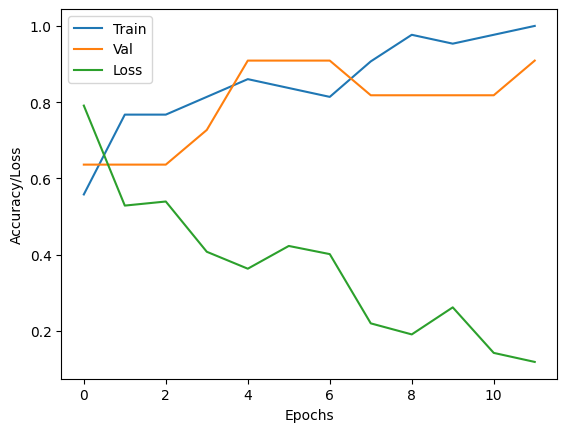

In [ ]:
plt.plot(np.arange(len(train_acc_values)), train_acc_values, label="Train")
plt.plot(np.arange(len(train_acc_values)), val_acc_values, label="Val")
plt.plot(np.arange(len(train_acc_values)), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy/Loss")
plt.legend()
plt.show()

In [46]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.67      0.67      0.67         6

    accuracy                           0.71        14
   macro avg       0.71      0.71      0.71        14
weighted avg       0.71      0.71      0.71        14



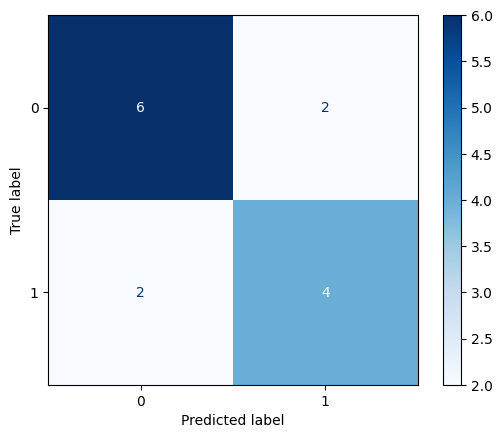

In [47]:
predictions = model.predict(X_test_scaled).argmax(axis=1)

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, predictions))

# Confusion matrix
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", xticks_rotation=0)